In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from datetime import datetime
import unicodedata
from unidecode import unidecode
import re
import copy
import pickle
import statsmodels.api as sm
from scipy.stats import norm, multivariate_normal
from scipy.stats import weibull_min
from adjustText import adjust_text

We first load the required data and results from previous notebooks 

In [2]:
import pickle

# Load game events
with open('data/game_events.pkl', 'rb') as f:
    game_events = pickle.load(f)

# Load mappings of names to player ids
with open('data/all_name_to_id.pkl', 'rb') as f:
    all_name_to_id = pickle.load(f)

with open('data/first_name_to_id.pkl', 'rb') as f:
    first_name_to_id = pickle.load(f)

with open('data/last_name_to_id.pkl', 'rb') as f:
    last_name_to_id = pickle.load(f)

# Load player ratings dictionary (key = player id)
with open('data/player_ratings.pkl', 'rb') as f:
    player_ratings = pickle.load(f)

# Load regular table of players (just in case)
with open('data/all_fifa_player_ratings.pkl', 'rb') as f:
    all_fifa_ratings = pickle.load(f)

# Load xg model parameters
with open('data/xg_rate_parameters.pkl', 'rb') as f:
    xg_rate_parameters = pickle.load(f)



# Load xg model data matrix 
with open('data/xg_data_matrix.pkl', 'rb') as f:
    data_with_dummies = pickle.load(f)

# Load general data matrix
with open('data/general_data_matrix.pkl', 'rb') as f:
    data = pickle.load(f)



# Load xg model 
with open('data/xg_model.pkl', 'rb') as f:
    xg_model = pickle.load(f)

#load game_state_correlations 
with open('data/game_state_correlations.pkl', 'rb') as f:
    game_state_rho = pickle.load(f)


We next define functions that allow us to match players to their FIFA rating

In [3]:
#function to find player id if their name number combination is unique enough 
def find_player_id(first_key,last_key,first_name_to_id_dict,last_name_to_id_dict):
    #get player id(s) given jersey and team info as sets, last name takes priority
    try:
        first_player_id = first_name_to_id_dict[first_key]
    except:
        first_player_id = set()
    try:
        last_player_id = last_name_to_id_dict[last_key]
    except:
        last_player_id = set()
    if len(last_player_id) == 1:
        player_id = list(last_player_id)[0]
    elif len(first_player_id) == 1:
        player_id = list(first_player_id)[0]
    else:
        cand = first_player_id.intersection(last_player_id)
        if len(cand) == 1:
            player_id = list(cand)[0]
        else:
            player_id = None
    return player_id

In [4]:

def search_name_in_table(first,last,table):
    name = first.lower() + "-" + last.lower()
    table_name = table[(table['player_url'].str.contains(name))]['player_id']
    player_id = set([v for v in table_name])
    if len(player_id)  == 1:
        return list(player_id)[0]
    else:
        player_id = None
    if player_id is None:
        table_name = table[(table['player_url'].str.contains(first.lower())) & (table['player_url'].str.contains(last.lower()))]['player_id']
        player_id = set([v for v in table_name])
        if len(player_id)  == 1:
            return list(player_id)[0]
        else:
            return None

In [5]:
#function to get fifa_ratings for each player on the field
def lineup_to_fifa_substitution(first_name_to_id_dict,last_name_to_id_dict,all_name_to_id_dict,player_table,player_rating_dict,lineup,roster_dict,fifa_year, team_name):
    #get roster names from numbers
    lineup_names = []
    lineup_numbers = []
    for key in lineup:
        lineup_numbers.append(key)
        name = roster_dict[key]
        name = unidecode(name).upper().split()
        lineup_names.append([name[0],name[-1]])
    #get nuber of players on field 
    n = len(lineup_names)
    #initialize stat list fo reach player 
    offense = []
    defense = []
    no_found = {}
    for j in range(n):
        #key for first name dictionary 
        first_key = tuple((lineup_names[j][0],team_name,lineup_numbers[j]))
        #key for last name dictionary 
        last_key = tuple((lineup_names[j][1],team_name,lineup_numbers[j]))
        #find player id 
        player_id = find_player_id(first_key,last_key,first_name_to_id_dict,last_name_to_id_dict)
        #if no one is found, switch order of first and last name (asian players tend to have this ordering)
        if player_id is None:
            player_id = find_player_id(last_key,first_key,first_name_to_id_dict,last_name_to_id_dict)
        #if no one is found, check to see if their first and last name combination is unique 
        if player_id is None:
            name = tuple((first_key[0],last_key[0]))
            if name in all_name_to_id_dict:
                cand = all_name_to_id_dict[name]
                if len(cand) == 1:
                    player_id = list(cand)[0]
        #if not found, look for thier name in the player database (time consuming)
        if player_id is None:
            player_id = search_name_in_table(first_key[0],last_key[0],player_table)
        #if not found, add to dictionary 
        if player_id is None:
            #print("player not found")
            no_found.update({tuple((lineup_names[j][0],lineup_names[j][1],team_name,lineup_numbers[j])):1})
            continue
        

        #Once we find a player we can gather their stats
        #if they have this exact player's stats ina  fifa version that corresponds to the year we want we are done 
        if fifa_year in player_rating_dict[player_id]:
            stats = player_rating_dict[player_id][fifa_year]
        #otherwise, get closest fifa year
        else:
            #prefer using an earluer year vs a later year 
            years = list(player_rating_dict[player_id].keys())
            years_diff = [abs(v + 0.5 -fifa_year) for v in player_rating_dict[player_id]]
            #get index order from smallest to largest
            closest_year = years[sorted(range(len(years)), key=lambda x: years_diff[x])[0]]
            #get stats ffrom closest year
            stats = player_rating_dict[player_id][closest_year]
        #add stats to list 
        offense.append(stats[0])
        defense.append(stats[1])

    return [offense,defense],no_found
    

In [6]:
#function to get fifa_ratings for each player on the field
def lineup_to_fifa(first_name_to_id_dict,last_name_to_id_dict,all_name_to_id_dict,player_table,player_rating_dict,lineup,roster_dict,fifa_year, team_name):
    #get roster names from numbers
    lineup_names = []
    lineup_numbers = []
    for key in lineup:
        lineup_numbers.append(key)
        name = roster_dict[key]
        name = unidecode(name).upper().split()
        lineup_names.append([name[0],name[-1]])
    #get nuber of players on field 
    n = len(lineup_names)
    #initialize stat list fo reach player 
    goalkeeping = []
    offense = []
    defense = []
    no_found = {}
    for j in range(n):
        #key for first name dictionary 
        first_key = tuple((lineup_names[j][0],team_name,lineup_numbers[j]))
        #key for last name dictionary 
        last_key = tuple((lineup_names[j][1],team_name,lineup_numbers[j]))
        #find player id 
        player_id = find_player_id(first_key,last_key,first_name_to_id_dict,last_name_to_id_dict)
        #if no one is found, switch order of first and last name (asian players tend to have this ordering)
        if player_id is None:
            player_id = find_player_id(last_key,first_key,first_name_to_id_dict,last_name_to_id_dict)
        #if no one is found, check to see if their first and last name combination is unique 
        if player_id is None:
            name = tuple((first_key[0],last_key[0]))
            if name in all_name_to_id_dict:
                cand = all_name_to_id_dict[name]
                if len(cand) == 1:
                    player_id = list(cand)[0]
        #if not found, look for thier name in the player database (time consuming)
        if player_id is None:
            player_id = search_name_in_table(first_key[0],last_key[0],player_table)
        #if not found, add to dictionary 
        if player_id is None:
            #print("player not found")
            no_found.update({tuple((lineup_names[j][0],lineup_names[j][1],team_name,lineup_numbers[j])):1})
            continue
        

        #Once we find a player we can gather their stats
        #if they have this exact player's stats ina  fifa version that corresponds to the year we want we are done 
        if fifa_year in player_rating_dict[player_id]:
            stats = player_rating_dict[player_id][fifa_year]
        #otherwise, get closest fifa year
        else:
            #prefer using an earluer year vs a later year 
            years = list(player_rating_dict[player_id].keys())
            years_diff = [abs(v + 0.5 -fifa_year) for v in player_rating_dict[player_id]]
            #get index order from smallest to largest
            closest_year = years[sorted(range(len(years)), key=lambda x: years_diff[x])[0]]
            #get stats ffrom closest year
            stats = player_rating_dict[player_id][closest_year]
        #add stats to list 
        offense.append(stats[0])
        defense.append(stats[1])
        goalkeeping.append(stats[2])
    #get goal
    gk = goalkeeping.index(max(goalkeeping))
    goalkeeping = max(goalkeeping)
    offense.pop(gk)
    defense.pop(gk)

    return [goalkeeping,offense,defense],no_found
    

# Estimating The Impact of a Substitution on Win Rate
One of the main ways in which a manager can affect the flow of a game is through making a substitution. In this notebook I will explore the impact of substitutions made by EPL managers and determine if they significatnly increase their team's win probability. Here I will define a tie as half of a win.

In [7]:
#Weighted linear Regression
#Covariates are offesnive fifa rating, opponent's defensive fifa rating, half, extra time, home/away, score differential (factor), fatigue, team?
#first make each column of dataframe
substitutions = []
for key in game_events:
    id_game = key
    #get game 
    game = game_events[key]
    #get rosters
    home_team_name = game['home_team_name']
    home_roster_dict = game['home_team_roster']
    #get away team and roster
    away_team_name = game['away_team_name']
    away_roster_dict = game['away_team_roster']

    
    #get fifa year 
    fifa_year = game['year']

    #formation = game['home_formation']
    #check stats
    n =  len(game['data'])
    #measure fatigue 
    fatigue_home = {v:0 for v in game['data'][0]['lineups'][home_team_name]}
    fatigue_away = {v:0 for v in game['data'][0]['lineups'][away_team_name]}
    for j in range(n):
        #add xg info
        home_score= game['data'][j]['score'][home_team_name]
        away_score = game['data'][j]['score'][away_team_name]
        #get what event caused change in game state
        change = game['data'][j]['change_type']
        #if it was a substituion, record this 
        if change[0] == "Substitution":
            #get team name and score differential when making sub
            if change[1][0] == home_team_name:
                score_diff = home_score - away_score
            else:
                score_diff = away_score - home_score
            #get participants in substitution
            player_replacing = change[1][1]
            player_replaced = change[1][2]
            #get time of substitution
            time_of_replacement = game['data'][j]['time_end']
            if change[1][0] == home_team_name:
                stat_change,_ = lineup_to_fifa_substitution(first_name_to_id,last_name_to_id,all_name_to_id,all_fifa_ratings,player_ratings,[player_replacing,player_replaced],home_roster_dict,fifa_year,home_team_name)
            elif change[1][0] == away_team_name:
                stat_change,_ = lineup_to_fifa_substitution(first_name_to_id,last_name_to_id,all_name_to_id,all_fifa_ratings,player_ratings,[player_replacing,player_replaced],away_roster_dict,fifa_year,away_team_name)
            #record stat changes
            offense_change = stat_change[0][0] - stat_change[0][1]
            defense_change = stat_change[1][0] - stat_change[1][1]
            #append ot list
            substitutions.append(tuple((id_game,change[1][0], offense_change, defense_change, time_of_replacement,score_diff)))


    
    


In [8]:
#evaluate substituion effect
parameter_means = {}
for key in xg_rate_parameters:
    #record_mean for each parameter
    xg_model.params[key] = np.mean(xg_rate_parameters[key])
    parameter_means[key] = np.mean(xg_rate_parameters[key])

In [9]:
#Weighted linear Regression
#Covariates are offesnive fifa rating, opponent's defensive fifa rating, half, extra time, home/away, score differential (factor), fatigue, team?
#first make each column of dataframe
substitution_effect = []
substitutions = []
intercept = xg_model.params['const']
coefficients = xg_model.params.drop('const')
for key in game_events:
    id_game = key
    #get game 
    game = copy.deepcopy(game_events[key])
    #get rosters
    home_team_name = game['home_team_name']
    home_roster_dict = game['home_team_roster']
    #get away team and roster
    away_team_name = game['away_team_name']
    away_roster_dict = game['away_team_roster']
    #get fifa year 
    fifa_year = game['year']

    #formation = game['home_formation']
    #check stats
    n =  len(game['data'])
    #measure fatigue 
    fatigue_home = {v:0 for v in game['data'][0]['lineups'][home_team_name]}
    fatigue_away = {v:0 for v in game['data'][0]['lineups'][away_team_name]}
    for j in range(n):
        lineup_home = game['data'][j]['lineups'][home_team_name]
        lineup_away = game['data'][j]['lineups'][away_team_name]
        #get home stats 
        home_stats,no_found = lineup_to_fifa(first_name_to_id,last_name_to_id,all_name_to_id,all_fifa_ratings,player_ratings,lineup_home,home_roster_dict,fifa_year,home_team_name)
        if(len(no_found))>0:
            continue
        #get home stats 
        away_stats,no_found = lineup_to_fifa(first_name_to_id,last_name_to_id,all_name_to_id,all_fifa_ratings,player_ratings,lineup_away,away_roster_dict,fifa_year,away_team_name)
        if(len(no_found))>0:
            continue
        
        #add time info
        time_elapse = game['data'][j]['time_end'] - game['data'][j]['time_start']

        #get fatigue at start of period
        fatigue_home_before = copy.deepcopy(fatigue_home)
        fatigue_away_before = copy.deepcopy(fatigue_away)

        for key in lineup_home:
            if key in fatigue_home_before:
                continue
            else:
                fatigue_home_before[key] = 0

        for key in lineup_away:
            if key in fatigue_away_before:
                continue
            else:
                fatigue_away_before[key] = 0
        

        for key in lineup_home:
            if key in fatigue_home:
                fatigue_home[key]+= time_elapse
            else:
                fatigue_home[key] = time_elapse

        for key in lineup_away:
            if key in fatigue_away:
                fatigue_away[key]+= time_elapse
            else:
                fatigue_away[key] = time_elapse
        
        home_field_fatigue = np.mean([fatigue_home[v] + fatigue_home_before[v] for v in lineup_home])/2
        away_field_fatigue = np.mean([fatigue_away[v] + fatigue_away_before[v] for v in lineup_away])/2


        #add home stats
        home_offense = sum(home_stats[1])
        home_defense = sum(home_stats[2])
        #add home stats
        away_offense = sum(away_stats[1])
        away_defense = sum(away_stats[2])
        #add xg info
        home_score= game['data'][j]['score'][home_team_name]
        away_score = game['data'][j]['score'][away_team_name]
        score_diff = home_score - away_score
        #add halfa nd extra time info
        half_marker = game['data'][j]['half']
        extra = game['data'][j]['extra_time']
        
        #get what caused game state change
        change = game['data'][j]['change_type']

        home_game_state = {'offense':[home_offense],
                               'opp_defense':[away_defense],
                               'fatigue': [home_field_fatigue - away_field_fatigue],
                               'half_2': [int(half_marker == 2)],
                               'extra_time_1':[int(extra == 1)],
                               'home_1': [1],
                               'score_differential_down_2': [0],
                               'score_differential_down_3_plus': [0],
                               'score_differential_tied': [0],
                               'score_differential_up_1': [0],
                               'score_differential_up_2': [0],
                               'score_differential_up_3_plus': [0],
                               'const':[1]
                               }

        away_game_state = {'offense':[away_offense],
                               'opp_defense':[home_defense],
                               'fatigue': [away_field_fatigue - home_field_fatigue],
                               'half_2': [int(half_marker == 2)],
                               'extra_time_1':[int(extra == 1)],
                               'home_1': [0],
                               'score_differential_down_2': [0],
                               'score_differential_down_3_plus': [0],
                               'score_differential_tied': [0],
                               'score_differential_up_1': [0],
                               'score_differential_up_2': [0],
                               'score_differential_up_3_plus': [0],
                               'const':[1]
                               }
        

        #check if we made substitution
        if change[0] == "Substitution":
            #get participants in substitution
            player_replacing = change[1][1]
            player_replaced = change[1][2]
            #get copies of game states pre and post substitution
            away_game_state_pre_sub = copy.deepcopy(away_game_state)
            away_game_state_post_sub = copy.deepcopy(away_game_state)

            home_game_state_pre_sub = copy.deepcopy(home_game_state)
            home_game_state_post_sub = copy.deepcopy(home_game_state)

            #get home-away score 
            score_diff = home_score - away_score
            #get time of substitution
            time_of_replacement = game['data'][j]['time_end']
            #get team name and score differential when making sub
            if change[1][0] == home_team_name:
                fatigue_change = -fatigue_home[player_replaced]/11
                stat_change,_ = lineup_to_fifa_substitution(first_name_to_id,last_name_to_id,all_name_to_id,all_fifa_ratings,player_ratings,[player_replacing,player_replaced],home_roster_dict,fifa_year,home_team_name)
                offense_change = stat_change[0][0] - stat_change[0][1]
                defense_change = stat_change[1][0] - stat_change[1][1]
                home_game_state_post_sub['offense'][0] += offense_change
                away_game_state_post_sub['opp_defense'][0] += defense_change
                home_game_state_post_sub['fatigue'][0] += fatigue_change
                away_game_state_post_sub['fatigue'][0] -= fatigue_change
            else:
                fatigue_change = -fatigue_away[player_replaced]/11
                stat_change,_ = lineup_to_fifa_substitution(first_name_to_id,last_name_to_id,all_name_to_id,all_fifa_ratings,player_ratings,[player_replacing,player_replaced],away_roster_dict,fifa_year,away_team_name)
                offense_change = stat_change[0][0] - stat_change[0][1]
                defense_change = stat_change[1][0] - stat_change[1][1]
                away_game_state_post_sub['offense'][0] += offense_change
                home_game_state_post_sub['opp_defense'][0] += defense_change
                away_game_state_post_sub['fatigue'][0] += fatigue_change
                home_game_state_post_sub['fatigue'][0] -= fatigue_change
            
            # Create the DataFrame and add the constant
            X_away_pre_sub = sm.add_constant(pd.DataFrame(away_game_state_pre_sub))
            # Now you can use it for prediction
            away_rate_pre_sub = np.dot(X_away_pre_sub[coefficients.index].values.flatten(), coefficients.values) + intercept

            X_away_post_sub = sm.add_constant(pd.DataFrame(away_game_state_post_sub))
            away_rate_post_sub = np.dot(X_away_post_sub[coefficients.index].values.flatten(), coefficients.values) + intercept

            X_home_pre_sub = sm.add_constant(pd.DataFrame(home_game_state_pre_sub))
            home_rate_pre_sub = np.dot(X_home_pre_sub[coefficients.index].values.flatten(), coefficients.values) + intercept

            X_home_post_sub = sm.add_constant(pd.DataFrame(home_game_state_post_sub))
            home_rate_post_sub = np.dot(X_home_post_sub[coefficients.index].values.flatten(), coefficients.values) + intercept

            substitution_effect.append({"game_id":id_game,'year':fifa_year ,'time_start': time_of_replacement,'half':half_marker, 'extra_time':extra, 'score_differential': score_diff,'teams':[home_team_name,away_team_name],
                                         'replacement_team': change[1][0], 'pre_sub_rates':[home_rate_pre_sub,away_rate_pre_sub],
                                           'post_sub_rates':[home_rate_post_sub,away_rate_post_sub],'fatigue':[home_game_state_post_sub['fatigue'],away_game_state_post_sub['fatigue']]
                                           })
            substitutions.append(tuple((id_game,change[1][0], offense_change, defense_change, time_of_replacement,score_diff)))
    


In [10]:
#evaluate substituion effect
parameter_means = {}
for key in xg_rate_parameters:
    #record_mean for each parameter
    parameter_means[key] = np.mean(xg_rate_parameters[key])

In [11]:
#record effect of each substitution
sub_effect = []
break_even_time = []
for sub in substitutions:
    sub_effect.append(sub[2]*parameter_means['offense'] - sub[3]*parameter_means['opp_defense'])
    break_even_time.append(max(0,0.5*sub_effect[-1]*11/parameter_means['fatigue']))

## Delta G Heuristic
With soccer being a game decided by which team scores the most goals, it is reasonable to deem substitutions that increase a team's xg rate or decreases the opponent's xg rate as "good"[CITE]. Substitution affects the game state by increasing/decreasing the total offensive and defensive ratings for the team as well as lowering the fatigue for the team overall. Let $\Delta O, \Delta D$ and $\Delta T$ be the change in offensive rating, defensive rating, and fatigue that the substitution causes. Then the overall effect of the substitution on the goal rate is 
$$\Delta G = \Delta O \beta_O - \Delta D \beta_D - 2\Delta T \beta_F$$
where $\beta_O$, $\beta_D$, and $\beta_F$ are the effects of team offense, team defense, and team fatigue. A decision rule based on $\Delta G$ being positive or not corresponds to the notion that a substitution is preferable when the net change in xg rate is to the substituting teams favor. Given that overall player ability is immutable within game, the only variable that a manager can affect is $\Delta T$, that is the time of the substitution. Define the break even time of a substitution to be the minimum change in fatigue needed to make $\Delta G$ 0. Assume that the substituted player has played the entire game up until that point and that no ejections have occurred.Then the time at which which making a substitution is break even to the overall goal scoring rate is 
$$T^\star = 11(\frac{\Delta O \beta_O - \Delta D \beta_D}{2\beta_F})$$ 
This is what we call the break even time. As seen in the plots below, teams are pretty static in their substitution patterns, tending to mostly substitute at the 80 minute mark, 

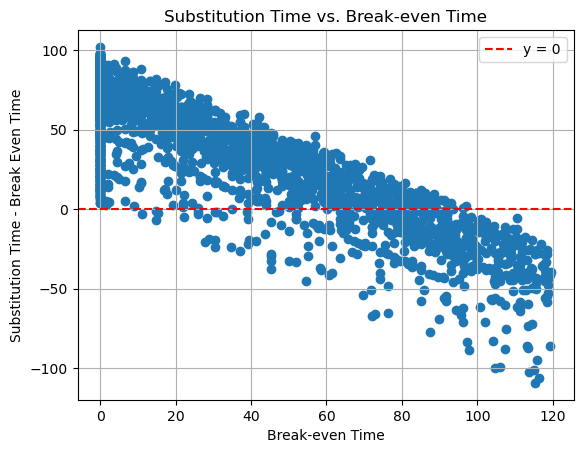

In [12]:
# Assuming B and C are defined
break_even_sub_time = np.array([break_even_time[j] for j in range(len(substitutions)) if break_even_time[j] < 120 and substitutions[j][5]  == 0])
actual_sub_time = np.array([substitutions[j][4] for j in range(len(substitutions)) if break_even_time[j] < 120 and substitutions[j][5]  == 0])

# Create the scatter plot
plt.scatter(break_even_sub_time, actual_sub_time - break_even_sub_time)

# Add the horizontal red line at y = 0
plt.axhline(0, color='red', linestyle='--', label='y = 0')

# Add labels and a title
plt.xlabel('Break-even Time')
plt.ylabel('Substitution Time - Break Even Time')
plt.title('Substitution Time vs. Break-even Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

Text(0.5, 1.0, 'Histogram of EPL Substitution Times')

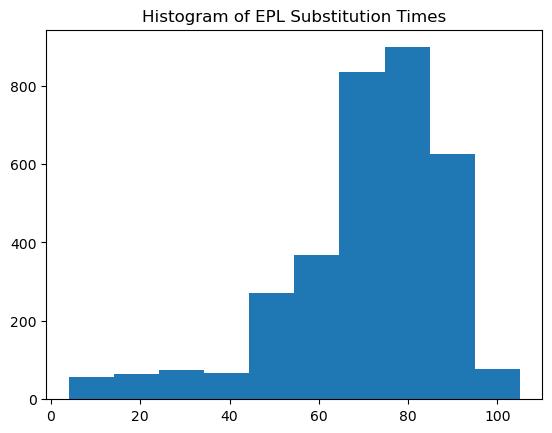

In [13]:
plt.hist(actual_sub_time)
plt.title("Histogram of EPL Substitution Times")

## Evaluating EPL Mangers for the 2017-2018 Season
We evaluate the change in win probability that substitutions made during the 2017-2018 EPL season. As explained earlier a tie counts as half a win so if the probability of a tie goes from 0.8 to 0.9 then it increases the win probability by 0.05. 

In [14]:
# Function to simulate a goal
def simulate_goal(r1, r2, rho, time_remaining, seed=None):
    # Set the seed if provided
    if seed is not None:
        np.random.seed(seed)
    
    # Simulate from a bivariate Gaussian with correlation rho
    mean = [0, 0]  # Mean of the bivariate normal distribution
    cov = [[1, rho], [rho, 1]]  # Covariance matrix
    # Create a multivariate normal distribution object
    rv = multivariate_normal(mean, cov)
    # Get values
    BVN = rv.rvs(size=1)
    # Turn into uniforms
    U1 = norm.cdf(BVN[0])
    U2 = norm.cdf(BVN[1])
    # Turn into Weibulls
    W1 = weibull_min.ppf(U1, 1.1146, loc=0, scale=1/r1)
    W2 = weibull_min.ppf(U2, 1.1146, loc=0, scale=1/r2)

    # Get minimum and see if it occurs before time ends
    if W1 < W2 and W1 < time_remaining:
        return [W1, 1]
    elif W2 < W1 and W2 < time_remaining:
        return [W2, 2]
    else:
        return [time_remaining, 0]

# Function to simulate a game
def simulate_game(r1, r2, half, extra_time, scores_initial, rhos, parameter_means, time_start, seed=None):
    scores = scores_initial.copy()
    score_differential = scores[0] - scores[1]
    if score_differential != 0:
        S = "up_down"
    else:
        S = "tied"
    if score_differential == 0:
        score_effect_1 = parameter_means['score_differential_tied']
        score_effect_2 = parameter_means['score_differential_tied']
    elif score_differential == 1:
        score_effect_1 = parameter_means['score_differential_up_1']
        score_effect_2 = 0
    elif score_differential == -1:
        score_effect_1 = 0
        score_effect_2 = parameter_means['score_differential_up_1']
    elif score_differential == 2:
        score_effect_1 = parameter_means['score_differential_up_2']
        score_effect_2 = parameter_means['score_differential_down_2']
    elif score_differential == -2:
        score_effect_1 = parameter_means['score_differential_down_2']
        score_effect_2 = parameter_means['score_differential_up_2']
    elif score_differential >= 3:
        score_effect_1 = parameter_means['score_differential_up_3_plus']
        score_effect_2 = parameter_means['score_differential_down_3_plus']
    elif score_differential <= -3:
        score_effect_1 = parameter_means['score_differential_down_3_plus']
        score_effect_2 = parameter_means['score_differential_up_3_plus']
    
    # Get rho 
    rho = rhos[tuple((S, half, extra_time))][0]

    # Set the seed if provided
    if seed is not None:
        np.random.seed(seed)
    else:
        seed = np.random.randint(1e8)

    if half == 1 and time_start < 45:
        time_remaining = 45 - time_start
        # Simulate next goal 
        next_goal = simulate_goal(r1 + score_effect_1, r2 + score_effect_2, rho, time_remaining, seed)
        # Update goals and check if half ended 
        if next_goal[1] == 1:
            scores[0] += 1
            time_start += next_goal[0]
        elif next_goal[1] == 2:
            scores[1] += 1
            time_start += next_goal[0]
        elif next_goal[1] == 0:
            r1 = r1 + parameter_means['extra_time_1']
            r2 = r2 + parameter_means['extra_time_1']
            extra_time = 1
            time_start = 45
        seed = np.random.randint(1,1e8)
        return simulate_game(r1, r2, half, extra_time, scores, rhos, parameter_means, time_start, seed)

    elif half == 1 and extra_time == 1:
        time_remaining = 50 - time_start
        next_goal = simulate_goal(r1 + score_effect_1, r2 + score_effect_2, rho, time_remaining, seed)
        # Update goals and check if half ended 
        if next_goal[1] == 1:
            scores[0] += 1
            time_start += next_goal[0]
        elif next_goal[1] == 2:
            scores[1] += 1
            time_start += next_goal[0]
        elif next_goal[1] == 0:
            r1 = r1 + parameter_means['half_2']
            r2 = r2 + parameter_means['half_2']
            r1 = r1 - parameter_means['extra_time_1']
            r2 = r2 - parameter_means['extra_time_1']
            extra_time = 0
            half = 2
            time_start = 50
        seed = np.random.randint(1,1e8)
        return simulate_game(r1, r2, half, extra_time, scores, rhos, parameter_means, time_start, seed)

    elif half == 2 and time_start < 95:
        time_remaining = 95 - time_start
        next_goal = simulate_goal(r1 + score_effect_1, r2 + score_effect_2, rho, time_remaining, seed)
        # Update goals and check if half ended 
        if next_goal[1] == 1:
            scores[0] += 1
            time_start += next_goal[0]
        elif next_goal[1] == 2:
            scores[1] += 1
            time_start += next_goal[0]
        elif next_goal[1] == 0:
            r1 = r1 + parameter_means['extra_time_1']
            r2 = r2 + parameter_means['extra_time_1']
            extra_time = 1
            time_start = 95
        seed = np.random.randint(1,1e8)
        return simulate_game(r1, r2, half, extra_time, scores, rhos, parameter_means, time_start, seed )

    elif half == 2 and extra_time == 1:
        time_remaining = 100 - time_start
        next_goal = simulate_goal(r1 + score_effect_1, r2 + score_effect_2, rho, time_remaining, seed)
        # Update goals and check if half ended 
        if next_goal[1] == 1:
            scores[0] += 1
            time_start += next_goal[0]
        elif next_goal[1] == 2:
            scores[1] += 1
            time_start += next_goal[0]
        elif next_goal[1] == 0:
            extra_time = 0
            time_start = 100
        seed = np.random.randint(1,1e8)
        return simulate_game(r1, r2, half, extra_time, scores, rhos, parameter_means, time_start, seed)
    
    # If the game ends, return the score
    if half == 2 and time_start == 100:
        return scores

# Function to simulate multiple games
def simulate_games(r1, r2, half, extra_time, scores_initial, rhos, parameter_means, time_start, nsim, seed=None):
    results = [0, 0, 0]
    if seed is None:
        seed = np.random.randint(1,1e8)
    for j in range(nsim):
        # Get game result
        game_result = simulate_game(r1, r2, half, extra_time, scores_initial, rhos, parameter_means, time_start, seed+j)
        # Append result to list
        if game_result[0] > game_result[1]:
            results[0] += 1
        elif game_result[1] > game_result[0]:
            results[1] += 1
        else:
            results[2] += 1
    return [v / nsim for v in results]


In [15]:
#number of simulations to run per scenario 
nsim = 500
#win probability before and after based on actual substitution time 
win_prob_before = []
win_prob_after = []
#subsittuing team and the side they were on (home away neither)
side = []
substituting_team = []

#number of substituions made overall 
n = len(substitution_effect)
counter = 1
for j in range(n):
    print(j)
    sub = substitution_effect[j]
    #if year isnt 2017-2018 ignore it 
    if sub['year'] != 18:
        continue

    #switch sign if the team was away 
    if sub['replacement_team'] == sub['teams'][1]:
        #time_effect = -time_effect
        if sub['score_differential'] < 0:
            continue
        else:
            side.append([0,1,0])
    else:
        if sub['score_differential'] > 0:
            continue
        else:
            side.append([1,0,0])
    
    #add substituting team 
    substituting_team.append(sub['replacement_team'])


    #simualte game given we subbed in that player at the actual time
    pre_sub_simulation = simulate_games(r1 = sub['pre_sub_rates'][0],r2 = sub['pre_sub_rates'][1],half = sub['half'],extra_time = sub['extra_time'],scores_initial = [sub['score_differential'],0],rhos = game_state_rho, parameter_means = parameter_means, time_start = sub['time_start'],nsim = nsim,seed = 1)
    #simulate game given we didn't sub that player  
    post_sub_simulation = simulate_games(r1 = sub['post_sub_rates'][0],r2 = sub['post_sub_rates'][1],half = sub['half'],extra_time = sub['extra_time'],scores_initial = [sub['score_differential'],0],rhos = game_state_rho, parameter_means = parameter_means, time_start = sub['time_start'],nsim = nsim,seed = 1)

    #get corresponding win-loss-tie probabilities
    win_prob_before.append(pre_sub_simulation)
    win_prob_after.append(post_sub_simulation)
    
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [308]:
#assign each cubstitution to a team and make a dictionary 
n = len(substituting_team)
EPL_team_subs = {}
#iterate over each sub
for j in range(n):
    team = substituting_team[j]
    S = side[j]
    if S[0] == 1:
        effect = (win_prob_after[j][0] - win_prob_before[j][0]) + 0.5*(win_prob_after[j][2] - win_prob_before[j][2])
    elif S[1] == 1:
        effect = (win_prob_after[j][1] - win_prob_before[j][1]) + 0.5*(win_prob_after[j][2] - win_prob_before[j][2])  
    else:
        continue
    #add sub to teams key 
    if team not in EPL_team_subs:
        EPL_team_subs[team] = [effect*100]
    else:
        EPL_team_subs[team].append(effect*100)

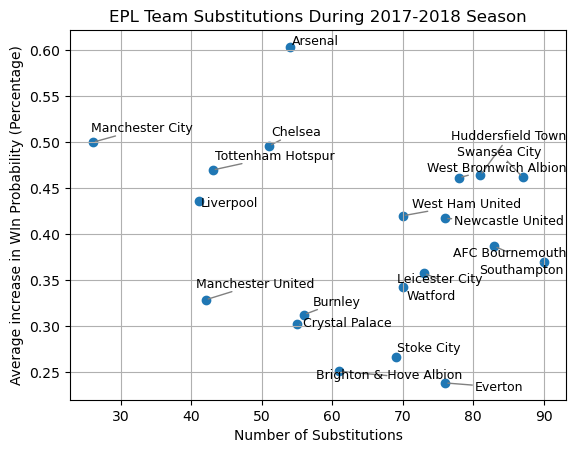

In [339]:
#average increase in win pct due to substituion by team 
avg_effect = []
#number of subs this team made
num_effect = []
for team in EPL_team_subs:
    sub_effects = EPL_team_subs[team]
    smallest_indices = np.argsort(sub_effects)[:min(5,int(len(sub_effects)/20))]
    sub_effects = np.delete(sub_effects,smallest_indices)


    avg_effect.append(np.mean(sub_effects))
    num_effect.append(len(sub_effects))

# Scatter plot
plt.scatter(num_effect, avg_effect)

# Add labels for each point
texts = []
for i, team in enumerate(EPL_team_subs.keys()):
    texts.append(plt.text(num_effect[i], avg_effect[i], team, fontsize=9, ha='left'))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))


# Grid and labels
plt.grid(True)
plt.xlabel('Number of Substitutions')
plt.ylabel('Average increase in WIn Probability (Percentage)')
plt.title('EPL Team Substitutions During 2017-2018 Season')

#save plot
plt.savefig("figures/EPL_substitution_effects.pdf")
# Show plot
plt.show()

## Finding Minimum Substitution Time
In this section I will evaluate the minimum time at which making a substitution improves the win probability of a team. This will be done via binary search. I will stratify based on score differential and how many FIFA points the substitute loses. For example, if the substituting player loses 5 FIFA points in defnese, then the min sub time function will find the earliest point at which substituting improves our team's chances of winning given the score differential is K. We see that when we are up a goal, defense is the priority as we should never substitute a player that loses 10.9. or 8 defensive points (assuming that they don't gain any offensive points). When we are down a goal, offense is the priority. 

In [16]:
#function to get minimum time at which a substitution is good
def min_sub_time(r1,r2,skill_loss_offense,skill_loss_defense,scores_initial,acc,nsim):
    time_min = 0
    time_max = 90
    while time_max - time_min > acc:
        #get midpoint of time 
        time_mid = 0.5*(time_max + time_min)
        #get half and extra time indicators
        if time_mid < 50:
            half = 1
        else:
            half = 2
        if (time_mid >= 45 and time_mid < 50) or (time_mid >= 95 and time_mid < 100):
            extra_time = 1
        else:
            extra_time = 0
        #get fatigue effect at this point
        fatigue_effect = -parameter_means['fatigue']*time_mid/11
        #get effect due to skill loss
        skill_effect_offense = parameter_means['offense']*skill_loss_offense
        skill_effect_defense = parameter_means['opp_defense']* skill_loss_defense
        #compute win-loss-tie probs if no sub
        no_sub_prob = simulate_games(r1 = r1,r2 = r2, half = half,extra_time=extra_time, scores_initial=scores_initial,rhos = game_state_rho, parameter_means=parameter_means, time_start = time_mid, nsim = nsim, seed = 1)
        #compute win-loss-tie probs if sub
        sub_prob = simulate_games(r1 = r1 + fatigue_effect + skill_effect_offense,r2 = r2 - fatigue_effect + skill_effect_defense, half = half,extra_time=extra_time, scores_initial=scores_initial,rhos = game_state_rho, parameter_means=parameter_means, time_start = time_mid, nsim = nsim, seed = 1)
        #get win probability difference. tie is worth half a win
        win_prob_diff = (sub_prob[0] - no_sub_prob[0]) + 0.5*(sub_prob[2] - no_sub_prob[2])
        if win_prob_diff < 0:
            time_min = time_mid
        else:
            time_max = time_mid
    return (time_max)


In [17]:
r1 = 0.0125
r2 = 0.0125
skill_loss_offense = range(-10,0)
skill_loss_defense = range(-10,0)
min_time_offense = []
min_time_defense = []
for diff in range(-1,2):
    print(diff)
    offense_sub_time = []
    defense_sub_time = []
    for j in range(len(skill_loss_offense)):
        offense_sub_time.append(min_sub_time(r1 = r1, r2 = r2, skill_loss_offense=skill_loss_offense[j], skill_loss_defense=0, scores_initial = [diff,0], acc = 1, nsim = 3000))
        defense_sub_time.append(min_sub_time(r1 = r1, r2 = r2, skill_loss_offense=0, skill_loss_defense=skill_loss_defense[j], scores_initial = [diff,0], acc = 1, nsim = 3000))
    min_time_offense.append(offense_sub_time)
    min_time_defense.append(defense_sub_time)


-1


KeyboardInterrupt: 

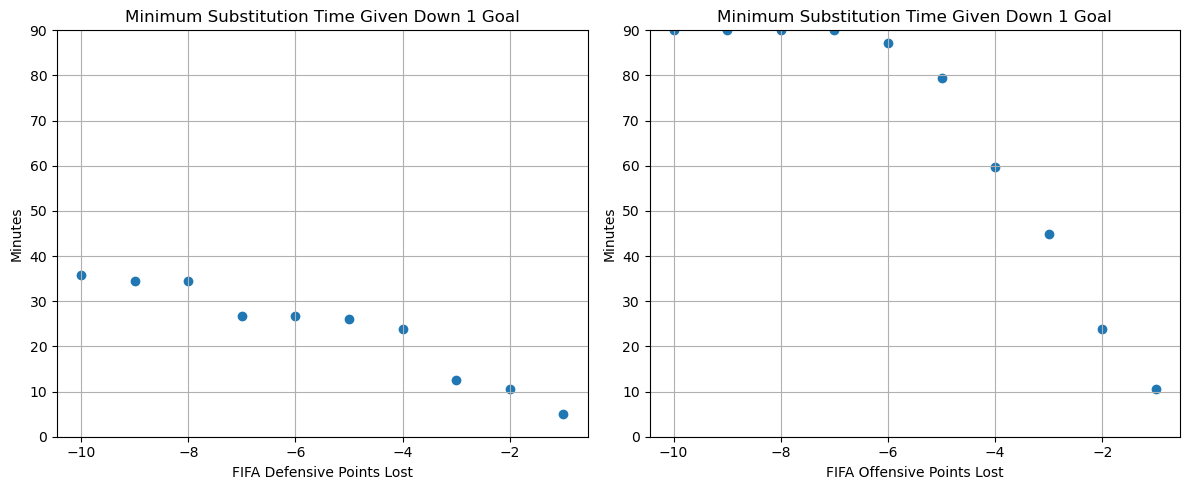

In [354]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# First subplot
ax1.scatter(range(-10, 0), min_time_defense[0])
ax1.grid(True)
ax1.set_title("Minimum Substitution Time Given Down 1 Goal")
ax1.set_xlabel("FIFA Defensive Points Lost")
ax1.set_ylabel("Minutes")

# Second subplot
ax2.scatter(range(-10, 0), min_time_offense[0])
ax2.grid(True)
ax2.set_title("Minimum Substitution Time Given Down 1 Goal")
ax2.set_xlabel("FIFA Offensive Points Lost")
ax2.set_ylabel("Minutes")

ax1.set_ylim(0,90)
ax2.set_ylim(0,90)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

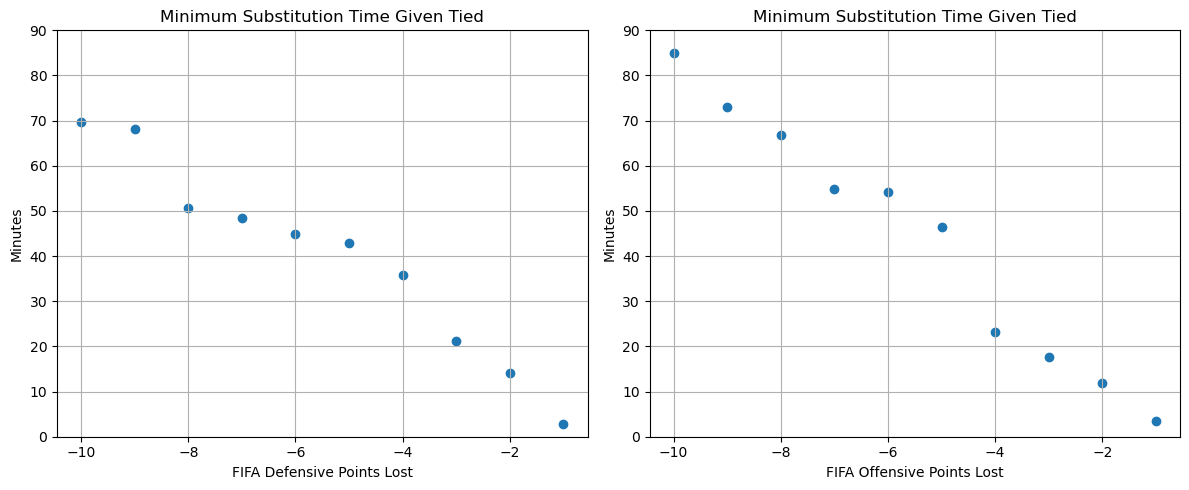

In [356]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# First subplot
ax1.scatter(range(-10, 0), min_time_defense[1])
ax1.grid(True)
ax1.set_title("Minimum Substitution Time Given Tied")
ax1.set_xlabel("FIFA Defensive Points Lost")
ax1.set_ylabel("Minutes")

# Second subplot
ax2.scatter(range(-10, 0), min_time_offense[1])
ax2.grid(True)
ax2.set_title("Minimum Substitution Time Given Tied")
ax2.set_xlabel("FIFA Offensive Points Lost")
ax2.set_ylabel("Minutes")

ax1.set_ylim(0,90)
ax2.set_ylim(0,90)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

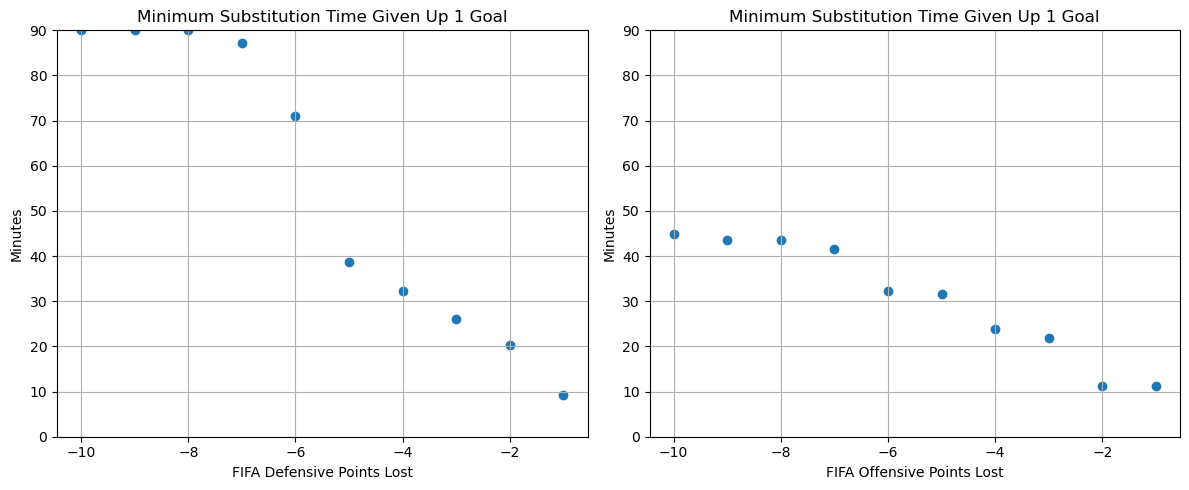

In [353]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# First subplot
ax1.scatter(range(-10, 0), min_time_defense[2])
ax1.grid(True)
ax1.set_title("Minimum Substitution Time Given Up 1 Goal")
ax1.set_xlabel("FIFA Defensive Points Lost")
ax1.set_ylabel("Minutes")

# Second subplot
ax2.scatter(range(-10, 0), min_time_offense[2])
ax2.grid(True)
ax2.set_title("Minimum Substitution Time Given Up 1 Goal")
ax2.set_xlabel("FIFA Offensive Points Lost")
ax2.set_ylabel("Minutes")

ax1.set_ylim(0,90)
ax2.set_ylim(0,90)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## France 2022 World Cup Substitution
We now evaluate the effect of the 2022 world cup substituion that Didier Deschamps made in the 2022 World cup final. To do this, we simply replace the two players (Dembele and Giroud) that were replaced and evalaute the win probability change. 

In [18]:
#IDs for Frances players who were not subbed
France = [231747,241486,201535,229558,232656,241637,210008,194765]
#IDs for frances two players that were substituted
France_sub = [231443,178509]
#IDs for frances two players that were replacing them 
France_replace = [237679,228093]
#IDs for Argentinas players 
Argentina = [233084,232488,192366,211256,239837,247090,212616,158023,246191,183898]

In [19]:
France_offense = 0
France_defense = 0
France_sub_offense = 0
France_sub_defense = 0
France_rep_offense = 0
France_rep_defense = 0
Argentina_offense = 0
Argentina_defense = 0
for player in France:
    France_offense += player_ratings[player][23][0]
    France_defense += player_ratings[player][23][1]
for player in France_sub:
    France_sub_offense += player_ratings[player][23][0]
    France_sub_defense += player_ratings[player][23][1]
for player in France_replace:
    France_rep_offense += player_ratings[player][23][0]
    France_rep_defense += player_ratings[player][23][1]
for player in Argentina:
    Argentina_offense += player_ratings[player][23][0]
    Argentina_defense += player_ratings[player][23][1]


In [20]:
intercept = xg_model.params['const']
coefficients = xg_model.params.drop('const')

France_state_pre = {'offense':[France_offense + France_sub_offense ],
                               'opp_defense':[Argentina_defense],
                               'fatigue': [0],
                               'half_2': [0],
                               'extra_time_1':[0],
                               'home_1': [0],
                               'score_differential_down_2': [1],
                               'score_differential_down_3_plus': [0],
                               'score_differential_tied': [0],
                               'score_differential_up_1': [0],
                               'score_differential_up_2': [0],
                               'score_differential_up_3_plus': [0],
                               'const':[1]
                               }

Argentina_state_pre = {'offense':[Argentina_offense],
                               'opp_defense':[France_defense + France_sub_defense ],
                               'fatigue': [0],
                               'half_2': [0],
                               'extra_time_1':[0],
                               'home_1': [0],
                               'score_differential_down_2': [0],
                               'score_differential_down_3_plus': [0],
                               'score_differential_tied': [0],
                               'score_differential_up_1': [0],
                               'score_differential_up_2': [1],
                               'score_differential_up_3_plus': [0],
                               'const':[1]
                               }


France_state_post = {'offense':[France_offense + France_rep_offense],
                               'opp_defense':[Argentina_defense],
                               'fatigue': [-80/11],
                               'half_2': [0],
                               'extra_time_1':[0],
                               'home_1': [0],
                               'score_differential_down_2': [0],
                               'score_differential_down_3_plus': [0],
                               'score_differential_tied': [0],
                               'score_differential_up_1': [0],
                               'score_differential_up_2': [0],
                               'score_differential_up_3_plus': [0],
                               'const':[1]
                               }

Argentina_state_post = {'offense':[Argentina_offense],
                               'opp_defense':[France_defense + France_rep_defense],
                               'fatigue': [80/11],
                               'half_2': [0],
                               'extra_time_1':[0],
                               'home_1': [0],
                               'score_differential_down_2': [0],
                               'score_differential_down_3_plus': [0],
                               'score_differential_tied': [0],
                               'score_differential_up_1': [0],
                               'score_differential_up_2': [0],
                               'score_differential_up_3_plus': [0],
                               'const':[1]
                               }

# Create the DataFrame and add the constant
France_pre_sub = sm.add_constant(pd.DataFrame(France_state_pre))
# Now you can use it for prediction
France_rate_pre_sub = np.dot(France_pre_sub[coefficients.index].values.flatten(), coefficients.values) + intercept

# Create the DataFrame and add the constant
France_post_sub = sm.add_constant(pd.DataFrame(France_state_post))
# Now you can use it for prediction
France_rate_post_sub = np.dot(France_post_sub[coefficients.index].values.flatten(), coefficients.values) + intercept

# Create the DataFrame and add the constant
Argentina_pre_sub = sm.add_constant(pd.DataFrame(Argentina_state_pre))
# Now you can use it for prediction
Argentina_rate_pre_sub = np.dot(Argentina_pre_sub[coefficients.index].values.flatten(), coefficients.values) + intercept


# Create the DataFrame and add the constant
Argentina_post_sub = sm.add_constant(pd.DataFrame(Argentina_state_post))
# Now you can use it for prediction
Argentina_rate_post_sub = np.dot(Argentina_post_sub[coefficients.index].values.flatten(), coefficients.values) + intercept

### Results
Finally we run the simulations and see that the substitution does improve France's chances althogh they are quite small either way.

In [21]:
no_sub_results = simulate_games(France_rate_pre_sub,Argentina_rate_pre_sub,half = 1,extra_time = 0,scores_initial = [-2,0],rhos = game_state_rho, parameter_means = parameter_means, time_start = 40,nsim = 5000,seed = 1)
sub_results = simulate_games(France_rate_post_sub,Argentina_rate_post_sub,half = 1,extra_time = 0,scores_initial = [-2,0],rhos = game_state_rho, parameter_means = parameter_means, time_start = 40,nsim = 5000,seed = 1)

In [22]:
no_sub_results

[0.03, 0.8876, 0.0824]

In [23]:
sub_results

[0.0348, 0.874, 0.0912]